# Imports

In [73]:
# Blibliotecas

import inflection
import numpy         as np
import pandas        as pd
# import psycopg2      as pg
import pandas.io.sql as psql
import seaborn       as sns 
import scikitplot    as skplt
import kds



from   matplotlib      import pyplot          as plt
from   sklearn         import preprocessing   as pp
from   sklearn         import model_selection as ms
from   sklearn         import ensemble        as en
from   sklearn         import neighbors       as nh


In [71]:
pip install kds

You should consider upgrading via the '/home/cleverton/.pyenv/versions/3.10.0/envs/Health_Ins_Pred/bin/python3.10 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## 0.1. Helper functions

In [4]:
def jupyter_settings():
    %matpoltlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [20,8]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style> ' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False )
    
    sns.set()

# Conexao Banco dados

## 0.1. Loading Description

In [5]:
df_raw = pd.read_csv( 'datasets/train.csv')


In [6]:
df_raw[['Vehicle_Age']].value_counts().reset_index()

,Vehicle_Age,0
0,1-2 Year,200316
1,< 1 Year,164786
2,> 2 Years,16007


# 1.0. Data Description

In [7]:
df1 = df_raw.copy()

In [8]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore( x )

cols_news = list( map( snakecase, cols_old ) )

df1.columns = cols_news

### 1.1. Data Dimension

In [9]:
print( 'Numero de linhas: {}'.format( df1.shape[0] ) )
print( 'Numero de colunas: {}'.format( df1.shape[1] ) )

Numero de linhas: 381109
Numero de colunas: 12


### 1.2. Data Types

In [10]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

### 1.3. Check NA

In [11]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

### 1.4. Data Descriptive

In [12]:
num_attributes = df1.select_dtypes( include=[ 'int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=[ 'int64', 'float64', 'datetime64[ns]'] )

In [13]:
# Central de tendencia - Media / Mediana
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T # Media
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T # Mediana

# Dispersion - std, min, max, range, sken, kurtosis

d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T


d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = [ 'attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0. Feature Engineering

In [14]:
df1[['vehicle_age']].value_counts().reset_index()

,vehicle_age,0
0,1-2 Year,200316
1,< 1 Year,164786
2,> 2 Years,16007


In [15]:
# vehicle age
df1['vehicle_age'] = df1['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' 
                                               else 'between_1_2_years' if x == '1-2 Year' 
                                               else 'below_1_year')

# vehicle damage
df1['vehicle_damage'] = df1['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

In [16]:
df1[['vehicle_age', 'response']].value_counts( normalize=True).reset_index()

,vehicle_age,response,0
0,between_1_2_years,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_years,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


# 3.0. Data Filtering

# 4.0. EDA

## 4.1. Univariate Analysis

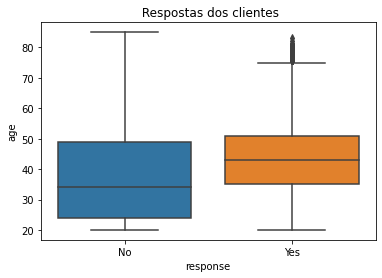

In [17]:
#Age
sns.boxplot( x='response', y='age', data=df1)
plt.title( ' Respostas dos clientes')
ax = plt.subplot()
# ax = ax.set_yticklabels(['Idade'])
ax = ax.set_xticklabels(['No', 'Yes'])

<AxesSubplot:xlabel='age', ylabel='Count'>

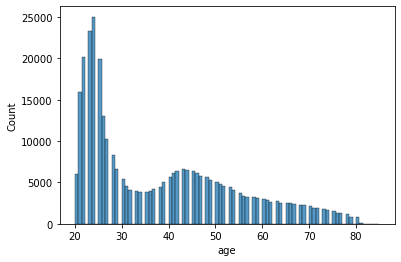

In [18]:
aux00 = df1.loc[df1['response'] == 0, 'age']
sns.histplot( aux00 )

<AxesSubplot:xlabel='age', ylabel='Count'>

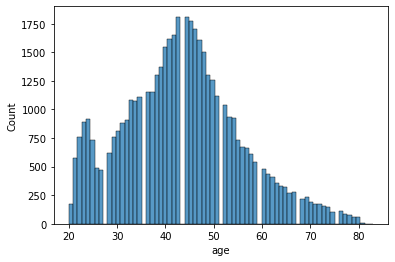

In [19]:
aux01 = df1.loc[ df1[ 'response' ] == 1, 'age' ]
sns.histplot( aux01 )

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

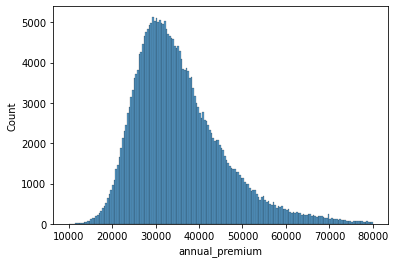

In [20]:
#Annual_Premium
aux = df1[( df1[ 'annual_premium' ] > 10000 ) & ( df1[ 'annual_premium' ] < 80000 ) ]
aux00 = aux.loc[ aux[ 'response' ] == 0, 'annual_premium' ]
sns.histplot( aux00 )

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

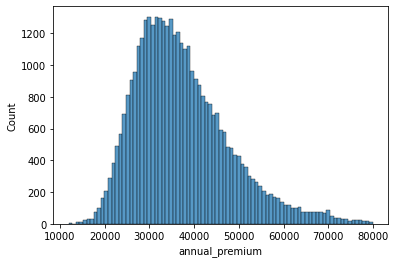

In [21]:
aux00 = aux.loc[ aux[ 'response' ] == 1, 'annual_premium' ]
sns.histplot( aux00 )



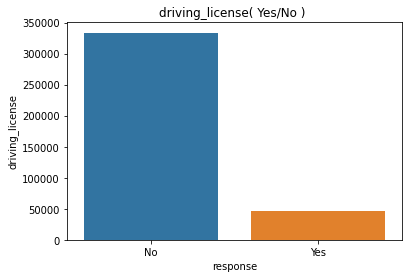

In [22]:
# Driving_License
aux = df1[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x = 'response', y = 'driving_license', data=aux )
plt.title('driving_license( Yes/No ) ')
ax = plt.subplot()
ax = ax.set_xticklabels(["No","Yes"])



In [23]:
# Quantidade de pessoas que tem ou não habilitação
aux.head()

,response,driving_license
0,0,333628
1,1,46669


In [24]:
# Quantidade de pessoas que tem ou não habilitação percentual
aux['driving_license'] = aux['driving_license'] / aux['driving_license'].sum()
aux.head()

,response,driving_license
0,0,0.877283
1,1,0.122717


In [25]:
#Gender

<AxesSubplot:xlabel='region_code', ylabel='id'>

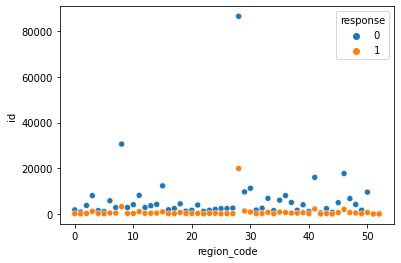

In [26]:
#Region_Code
aux0 = df1[['id', 'region_code', 'response']].groupby( ['region_code', 'response']).count().reset_index()
sns.scatterplot( x='region_code', y='id', hue='response', data=aux0)

In [27]:
#Previously_Insured 
pd.crosstab( df1['previously_insured'], df1['response'] ).apply( lambda x: x / x.sum(), axis=1 )
# sns.barplot( x = 'previously_insured', y = 'response', data=aux1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [28]:
#Vehicle_Age - Porcentagem
df1[['vehicle_age', 'response']].value_counts( normalize=True ).reset_index() # Normalize coloca em porcentagem


,vehicle_age,response,0
0,between_1_2_years,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_years,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


In [29]:
#Vehicle_Damage

<AxesSubplot:xlabel='response', ylabel='policy_sales_channel'>

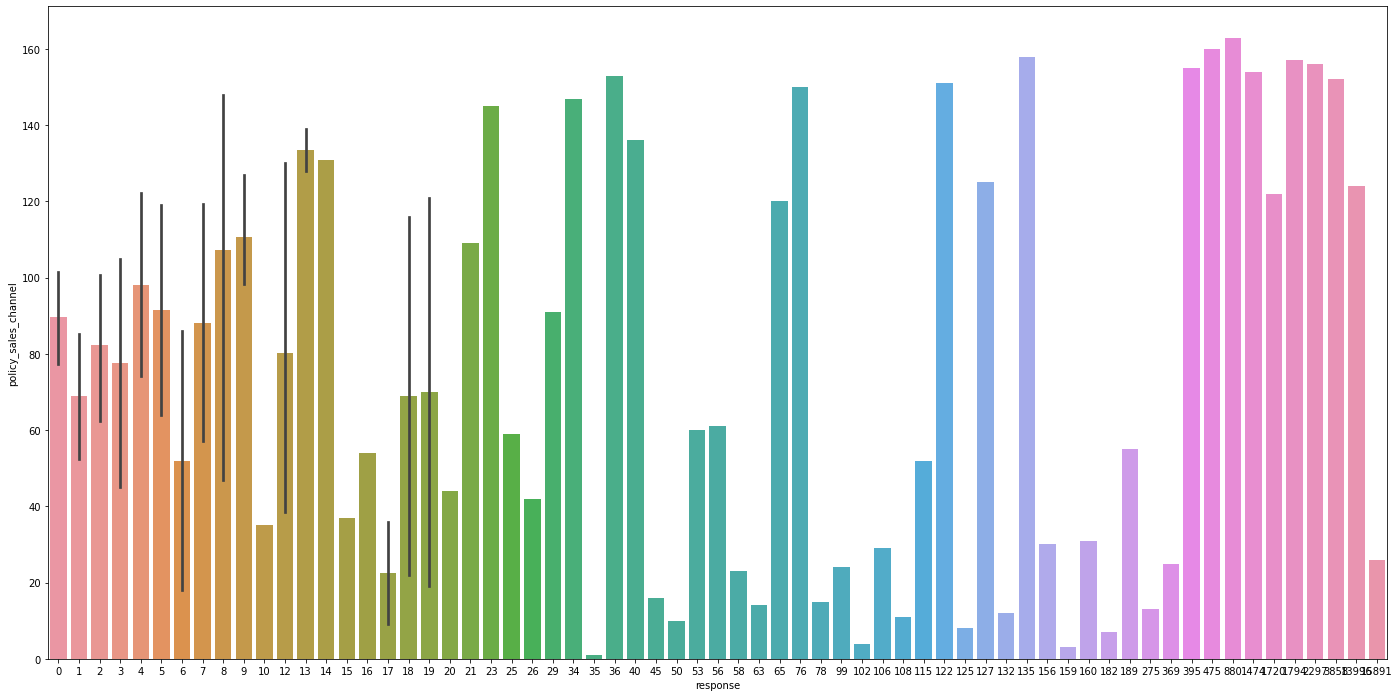

In [30]:
#Policy_Sales_Channel
plt.figure(figsize=(24, 12))
aux001 = df1[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux001)

<AxesSubplot:xlabel='response', ylabel='vintage'>

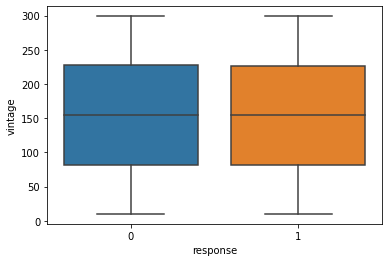

In [31]:
#Vintage
sns.boxplot(x='response', y='vintage', data=df1)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

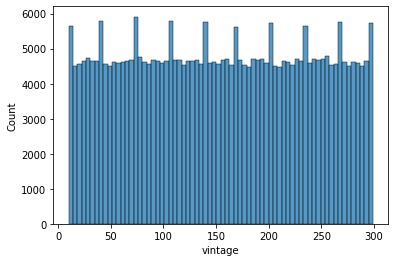

In [32]:
aux00 = df1.loc[df1['response'] == 0, 'vintage']
sns.histplot( aux00 )

<AxesSubplot:xlabel='vintage', ylabel='Count'>

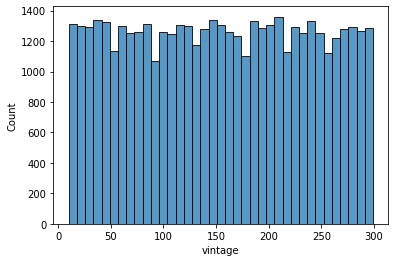

In [33]:
aux01 = df1.loc[df1['response'] == 1, 'vintage' ]
sns.histplot( aux01)

In [34]:
#Response

# 5.0. Data Preparation

In [35]:
df1 = df1.copy()

<AxesSubplot:xlabel='gender', ylabel='response'>

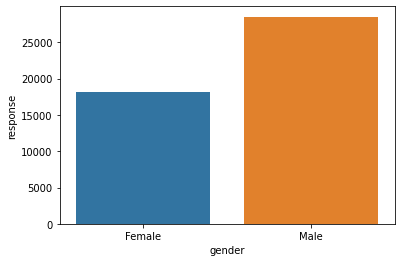

In [36]:
ax1 = df1[['gender', 'response']].groupby('gender').sum().reset_index()
sns.barplot( x='gender', y='response', data=ax1)

In [37]:
X =  df1.drop( 'response', axis=1 ) #fi
Y =  df1[ 'response' ].copy()#variavel resposta

x_train, x_val, y_train, y_val = ms.train_test_split( X, Y, test_size=0.20 )

df1 = pd.concat( [x_train, y_train], axis=1 )

## Standardization

In [38]:
ss = pp.StandardScaler()

# Annual_Premium
df1['annual_premium'] = ss.fit_transform( df1[[ 'annual_premium']].values )

## Rescaling

In [39]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df1['age'] = mms_age.fit_transform( df1[['age']].values )

# Vintage
df1['vintage'] = mms_vintage.fit_transform( df1[['vintage']].values )

## Encoder

In [40]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df1.groupby( 'gender' )['response'].mean()
df1.loc[:, 'gender'] = df1['gender'].map( target_encode_gender )

# Region_code -  Frequency Encoding / Target Encoding / Weighted Target Enconding
target_encode_region_code = df1.groupby('region_code')['response'].mean()
df1.loc[:, 'region_code' ] = df1[ 'region_code' ].map( target_encode_region_code )

# Vehicle_age -  One Hot Encondign / Order Enconding / Frequency Encoding
df1 = pd.get_dummies( df1, prefix='vehicle_age', columns=['vehicle_age'])

# Policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df1.groupby( 'policy_sales_channel' ).size() / len( df1 )
df1.loc[:, 'policy_sales_channel'] = df1[ 'policy_sales_channel'].map(fe_policy_sales_channel)

In [41]:
df1[['region_code', 'response']].groupby('region_code').sum().reset_index()

,region_code,response
0,0.039124,25
1,0.041109,83
2,0.057547,61
3,0.061665,217
4,0.062272,511
5,0.067201,109
6,0.067634,219
7,0.068918,100
8,0.070365,241
9,0.072262,161


# 5.4 Validation Preparation

In [42]:
# gender
x_val.loc[:, 'gender'] = x_val.loc[:, 'gender'].map( target_encode_gender )

# age
x_val.loc[:, 'age'] = mms_age.transform( x_val[[ 'age' ]].values )

# region_code
x_val.loc[:, 'region_code' ] = x_val.loc[:, 'region_code' ].map( target_encode_region_code )

# vehicle_age
x_val = pd.get_dummies( x_val, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_val.loc[:, 'annual_premium' ] = ss.transform( x_val[['annual_premium']].values )

# policy_sales_channel
x_val.loc[:, 'policy_sales_channel'] = x_val[ 'policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_val.loc[:, 'vintage' ] = mms_vintage.transform( x_val[['vintage']].values)

# fiilna
x_val = x_val.fillna( 0 )

# 6.0. Feature Selection

## 6.2 Features importancia

In [43]:
df2 = df1.copy()

In [44]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df2.drop( ['id','response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                         feature  importance
0                        vintage    0.271923
0                 annual_premium    0.244972
0                            age    0.164654
0                    region_code    0.106011
0                 vehicle_damage    0.070486
0           policy_sales_channel    0.060451
0             previously_insured    0.053990
0       vehicle_age_below_1_year    0.013879
0  vehicle_age_between_1_2_years    0.006408
0                         gender    0.004572
0       vehicle_age_over_2_years    0.002140
0                driving_license    0.000513


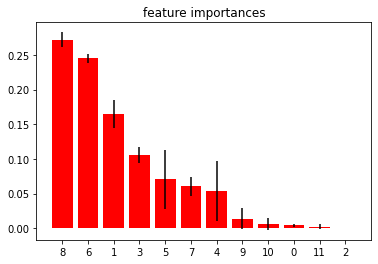

In [45]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0 )
indices = np.argsort( importances )[ ::-1 ]

# Print the feature ranking
print('Feature ranking:')
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df  = pd.concat( [df, aux], axis=0 )
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity_based feature importances of the forest
plt.figure()
plt.title( 'feature importances' )
plt.bar(range(x_train_n.shape[1] ), importances[indices], color='r', yerr=std[indices], align='center' )
plt.xticks(range(x_train_n.shape[1] ), indices)
plt.xlim( [-1, x_train_n.shape[1 ] ] )
plt.show()


# 7.0. Machine Learning

In [2]:
df1.head()

NameError: name 'df1' is not defined

In [60]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']


x_train = df2[ cols_selected ]
x_val = x_val[ cols_selected ]

In [58]:
y_val.head()

,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured
31129,0.678201,0.514468,0.015385,0.062272,1,0.056936,1
180587,0.010381,-1.630941,0.061538,0.110555,0,0.354102,1
315143,0.633218,0.611166,0.030769,0.095774,0,0.354102,1
312977,0.657439,0.544734,0.415385,0.187620,1,0.193865,0
374074,0.851211,0.139245,0.092308,0.123241,0,0.354102,1



## 7.1. KNN

In [69]:
# Model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=2 )

# Model training
knn_model.fit( x_train, y_train )

# Model prediction - Mede Poder de GENERALIZACAO  e nao de aprendizado
yhat_knn = knn_model.predict_proba( x_val )

In [77]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn);

ValueError: Cannot calculate Cumulative Gains for data with 30256 category/ies

In [ ]:
# 8.0. 

In [ ]:
# 9.0. 

In [ ]:
# 10.0. 